# COSAS SUELTAS

Terminar el arbol  
Luego sacar el subproducto de importacia de variables  
Luego hacer random forest  
Optimizarlos con gridsearchCV  
Sacar metricas, curvas roc, curvas de validacion (train vs test en ajustes de gridsearch)  
Agregar funcion de ganancia y custom treshold  
Y luego seguir probando modelos, si agregamos knn o naive bayes creo que se necesita escalar las variables. (Escalar ayuda al arbol?)

In [2]:
"""
PROBAR MUCHOS ARBOLES Y ENCONTRAR EL MEJOR


# Parámetros para optimizar en el GridSearchCV
param_grid = {
    'tree__max_depth': [5, 7, 10, 15],
    'tree__min_samples_split': [2, 5, 10, 12],
    'tree__min_samples_leaf': [1, 2, 4, 6],
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__max_features': ["sqrt", "log2", "auto", "None"],
    'tree__random_state': [42]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_arbol,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=funcion_ganancia,
    n_jobs=-1,  # usa todos los cores disponibles
    verbose=2
)

# Entrenar
grid_search.fit(X_train, y_train)

# Mejores parámetros y score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)

# Acceder al mejor modelo
best_pipeline = grid_search.best_estimator_
"""

'\nPROBAR MUCHOS ARBOLES Y ENCONTRAR EL MEJOR\n\n\n# Parámetros para optimizar en el GridSearchCV\nparam_grid = {\n    \'tree__max_depth\': [5, 7, 10, 15],\n    \'tree__min_samples_split\': [2, 5, 10, 12],\n    \'tree__min_samples_leaf\': [1, 2, 4, 6],\n    \'tree__criterion\': [\'gini\', \'entropy\', \'log_loss\'],\n    \'tree__max_features\': ["sqrt", "log2", "auto", "None"],\n    \'tree__random_state\': [42]\n}\n\n# Crear el GridSearchCV\ngrid_search = GridSearchCV(\n    estimator=pipeline_arbol,\n    param_grid=param_grid,\n    cv=5,  # 5-fold cross-validation\n    scoring=funcion_ganancia,\n    n_jobs=-1,  # usa todos los cores disponibles\n    verbose=2\n)\n\n# Entrenar\ngrid_search.fit(X_train, y_train)\n\n# Mejores parámetros y score\nprint("Mejores parámetros:", grid_search.best_params_)\nprint("Mejor score:", grid_search.best_score_)\n\n# Acceder al mejor modelo\nbest_pipeline = grid_search.best_estimator_\n'

In [3]:
"""
# Evaluar el pipeline entrenado
metricas = evaluar_modelo(
    pipeline=best_pipeline,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    nombre_modelo="Árbol de Decisión"
)
"""

'\n# Evaluar el pipeline entrenado\nmetricas = evaluar_modelo(\n    pipeline=best_pipeline,\n    X_train=X_train,\n    X_test=X_test,\n    y_train=y_train,\n    y_test=y_test,\n    nombre_modelo="Árbol de Decisión"\n)\n'

# Importaciones

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Agregamos modelos de ML
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc


# Funciones Auxiliares

In [5]:
def evaluar_modelo(pipeline, X_train, X_test, y_train, y_test, nombre_modelo="Modelo"):
    """
    Evalúa un pipeline de clasificación y muestra métricas completas.
    
    Parámetros:
    -----------
    pipeline : sklearn.pipeline.Pipeline
        Pipeline entrenado a evaluar
    X_train : pd.DataFrame
        Datos de entrenamiento
    X_test : pd.DataFrame
        Datos de test
    y_train : pd.Series
        Target de entrenamiento
    y_test : pd.Series
        Target de test
    nombre_modelo : str, opcional
        Nombre del modelo para los títulos
    
    Retorna:
    --------
    dict : Diccionario con las métricas principales
    """
    from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                                  classification_report, accuracy_score,
                                  precision_score, recall_score, f1_score)
    import matplotlib.pyplot as plt
    
    # Hacer predicciones
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    
    # Calcular métricas
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='weighted')
    recall = recall_score(y_test, y_pred_test, average='weighted')
    f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    # Imprimir resultados
    print("=" * 70)
    print(f"EVALUACIÓN: {nombre_modelo}")
    print("=" * 70)
    print(f"Accuracy en Train:        {acc_train:.4f}")
    print(f"Accuracy en Test:         {acc_test:.4f}")
    print(f"Diferencia (Overfitting): {acc_train - acc_test:.4f}")
    print(f"\nPrecision (weighted):     {precision:.4f}")
    print(f"Recall (weighted):        {recall:.4f}")
    print(f"F1-Score (weighted):      {f1:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    print("\n" + "=" * 70)
    print("MATRIZ DE CONFUSIÓN - TEST SET")
    print("=" * 70)
    print(cm)
    
    # Visualizar la matriz de confusión
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusión - {nombre_modelo} (Test Set)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Reporte de clasificación
    print("\n" + "=" * 70)
    print("REPORTE DE CLASIFICACIÓN - TEST SET")
    print("=" * 70)
    print(classification_report(y_test, y_pred_test))
    
    # Información del modelo (si tiene)
    if hasattr(pipeline, 'named_steps'):
        # Buscar el clasificador en el pipeline
        for step_name, step in pipeline.named_steps.items():
            if hasattr(step, 'get_depth'):  # Es un árbol
                print("\n" + "=" * 70)
                print(f"PARÁMETROS DEL ÁRBOL ({step_name})")
                print("=" * 70)
                print(f"Max Depth (configurado): {step.max_depth}")
                print(f"Profundidad Real:        {step.get_depth()}")
                print(f"Número de Hojas:         {step.get_n_leaves()}")
                print(f"Número de Features:      {step.n_features_in_}")
            elif hasattr(step, 'n_estimators'):  # Es un Random Forest o similar
                print("\n" + "=" * 70)
                print(f"PARÁMETROS DEL ENSEMBLE ({step_name})")
                print("=" * 70)
                print(f"Número de estimadores:   {step.n_estimators}")
                print(f"Max Depth:               {step.max_depth}")
                print(f"Número de Features:      {step.n_features_in_}")
    
    # Retornar métricas en un diccionario
    return {
        'accuracy_train': acc_train,
        'accuracy_test': acc_test,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'overfitting': acc_train - acc_test,
        'confusion_matrix': cm
    }


In [6]:
def visualizar_arbol_importancia(pipeline, X_train, model_step_name='tree', 
                                  class_names=None, title='Árbol de Decisión',
                                  max_depth_plot=3, top_n_features=20, 
                                  top_n_print=15, figsize_tree=(20, 12), 
                                  figsize_importance=(12, 8)):
    """
    Visualiza un árbol de decisión y la importancia de las variables.
    
    Parámetros:
    -----------
    pipeline : Pipeline
        Pipeline de sklearn que contiene el modelo de árbol
    X_train : DataFrame
        Datos de entrenamiento
    model_step_name : str, default='tree'
        Nombre del paso del modelo en el pipeline
    class_names : list, optional
        Nombres de las clases para la visualización
    title : str, default='Árbol de Decisión'
        Título para los gráficos
    max_depth_plot : int, default=3
        Profundidad máxima del árbol a visualizar
    top_n_features : int, default=20
        Número de features a mostrar en el gráfico de importancia
    top_n_print : int, default=15
        Número de features a imprimir en la tabla
    figsize_tree : tuple, default=(20, 12)
        Tamaño de la figura del árbol
    figsize_importance : tuple, default=(12, 8)
        Tamaño de la figura de importancia
    """
    from sklearn.tree import plot_tree
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Extraer el modelo del pipeline
    model = pipeline.named_steps[model_step_name]
    
    # Obtener los nombres de las features después de las transformaciones
    X_transformed = pipeline[:-1].transform(X_train)
    feature_names = X_transformed.columns.tolist()
    
    # Visualizar el árbol
    plt.figure(figsize=figsize_tree)
    plot_tree(model, 
              fontsize=10, 
              filled=True, 
              feature_names=feature_names, 
              class_names=class_names,
              max_depth=max_depth_plot,
              impurity=True,
              proportion=True)
    plt.title(f'{title}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ==== IMPORTANCIA DE VARIABLES ====
    print("\n" + "="*70)
    print("IMPORTANCIA DE LAS VARIABLES")
    print("="*70)
    
    # Obtener importancias
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Mostrar top features
    print(f"\nTop {top_n_print} variables más importantes:")
    print(feature_importance_df.head(top_n_print).to_string(index=False))
    
    # Visualizar importancias
    plt.figure(figsize=figsize_importance)
    top_features = feature_importance_df.head(top_n_features)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importancia', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title(f'Top {top_n_features} Variables Más Importantes - {title}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

In [7]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5, scoring='accuracy', n_jobs=-1):
    """
    Genera y muestra la curva de validación de un modelo.

    Parámetros:
    -----------
    estimator : estimador sklearn
        Modelo (o pipeline) a evaluar.
    X : pd.DataFrame o np.array
        Datos de entrada.
    y : pd.Series o np.array
        Target.
    param_name : str
        Nombre del hiperparámetro a variar (por ejemplo 'tree__max_depth').
    param_range : array-like
        Valores del hiperparámetro a evaluar.
    cv : int
        Número de folds en la validación cruzada.
    scoring : str
        Métrica para evaluar ('accuracy', 'roc_auc', etc.).
    n_jobs : int
        Cantidad de cores a usar.
    """
    train_scores, valid_scores = validation_curve(
        estimator, X, y, 
        param_name=param_name, 
        param_range=param_range, 
        cv=cv, 
        scoring=scoring, 
        n_jobs=n_jobs
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(param_range, train_mean, label="Train score", color="blue", marker='o')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.plot(param_range, valid_mean, label="Validation score", color="green", marker='o')
    plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color="green")
    
    plt.title(f"Validation Curve for {param_name}")
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Lectura del Dataframe

In [8]:
columnas_numericas = ['surface_total', 'rooms', 'bathrooms']

In [9]:
df = pd.read_csv('datasets/dptos_entrenamiento.csv')
df.set_index('id', inplace=True)
df.head(2)

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price_period,title,paga_comision
id,,,,,,,,,,,,,,,,,,,,
RDfa+E7upD0n5pptEfHdMg==,Propiedad,2020-01-08,2020-01-11,2020-01-08,-37.999860,-57.555031,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Venta depto dos ambientes con frente abierto,no paga
mL0EoZeEqENVokwugUrtow==,Propiedad,2020-01-17,2020-01-21,2020-01-17,-34.566363,-58.438766,Argentina,Capital Federal,Palermo,NaN,NaN,NaN,4.0,3.0,1.0,81.0,75.0,NaN,VENTA 4 AMBIENTES C COCHERA FIJA MUY LUMINOSO,paga


# Split train y test

In [10]:
encoder = OrdinalEncoder()
df['paga_comision_encoded'] = encoder.fit_transform(df[['paga_comision']])

df.drop(columns=['paga_comision'], inplace=True)
df['paga_comision_encoded'].astype('int64')

id
RDfa+E7upD0n5pptEfHdMg==    0
mL0EoZeEqENVokwugUrtow==    1
hOZOY5Bo9FzB3IR8V6TtiA==    0
JKfw+/BUerJ7cNjors3UBQ==    0
SBDKF7R+J2C+n4gWm4JrOw==    0
                           ..
SJ10BUgrdEGcpN625rUnvQ==    0
QRvbcLYpdFrsjDoarhQRxQ==    0
149re/PCUyrmtsbpa2SAOg==    0
W6mebjf8pbvzxLhmhLYiCQ==    0
5UlIUMHlRN2N2ChpjTMy6g==    0
Name: paga_comision_encoded, Length: 76984, dtype: int64

In [11]:
# Split 70-30
X = df.drop(columns="paga_comision_encoded")
y = df["paga_comision_encoded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=54)

# Preprocesamiento y prueba de modelos

# Función de Ganancia y Probabilidad de Corte


Universo Total = paga_comision('paga') + paga_comision('no_paga')  
ganancia = **100** * paga_comision('paga') - **50** * paga_comision('no_paga')  
ganancia = **150** * paga_comision('paga') - **50** * paga_comision('paga') - **50** * paga_comision('no_paga')  

150 * paga_comision('paga') - 50 * paga_comision('paga') - 50 * paga_comision('no_paga') > 0

150 * paga_comision('paga') - 50 * (paga_comision('paga') + paga_comision('no_paga')) > 0

150 * paga_comision('paga') > 50 * (paga_comision('paga') + paga_comision('no_paga'))

paga_comision('paga') > (50/150) * (paga_comision('paga') + paga_comision('no_paga'))

paga_comision('paga') / (paga_comision('paga') + paga_comision('no_paga')) > 50/150

Prob('paga') > 0.33

In [ ]:
def funcion_ganancia(clf, X, y_true):
    prob_corte = 0.33
    y_prob_pago = clf.predict_proba(X)[:, 1]
    
    ganancias = []
    for i in range(len(y_prob_pago)):
        if y_prob_pago[i] > prob_corte:
            if y_true.iloc[i] > 0:  
                ganancias.append(100)
            else:
                ganancias.append(-50)
    
    ganancia = sum(ganancias)
    return ganancia

# Transformaciones

## Enconding

In [13]:
# Pasé las transformaciones a un diccionario para hacerlas reusables.
ddtr_enc = {}
ddtr_enc["ct_oh_l1"] = ("oh_l1", OneHotEncoder(sparse_output=False, dtype=int, drop='first'), ["l1"])
ddtr_enc["ct_oh_l2"] = ("oh_l2", OneHotEncoder(sparse_output=False, dtype=int, drop='first'), ["l2"])


ct_enc = ColumnTransformer([ddtr_enc["ct_oh_l1"], 
                        ddtr_enc["ct_oh_l2"]])

In [14]:
class ColOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, encoder=None, columns=None):
        super().__init__()
        self.encoder = encoder or OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.columns = columns or []
        
    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self    
    
    def get_feature_names_out(self):
        return self.encoder.get_feature_names_out(self.columns)
    
    def transform(self, X):
        Xc = X.copy()
        # Aplicar one-hot y convertir a DataFrame
        encoded = self.encoder.transform(Xc[self.columns])
        encoded_df = pd.DataFrame(
            encoded,
            columns=self.get_feature_names_out(),
            index=Xc.index
        )
        # Reemplazar las columnas originales por las codificadas
        Xc.drop(self.columns, axis=1, inplace=True)
        Xc = pd.concat([Xc, encoded_df], axis=1)
        return Xc

## Outliers

In [ ]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    """
    Transformer personalizado para manejar outliers.
    Detecta outliers y los convierte en NaN.
    
    Parámetros:
    -----------
    columns : list, default=None
        Lista de columnas a procesar. Si es None, procesa todas las columnas.
    factor : float, default=1.5
        Factor multiplicador del IQR para definir los límites.
    """
    
    def __init__(self, columns=None, factor=1.5):
        self.columns = columns
        self.factor = factor
        self.lower_bounds = {}
        self.upper_bounds = {}
        self.outlier_counts = {}
        self.columns_ = None  # Columnas que realmente se procesarán
        
    def fit(self, X, y=None):
        """
        Calcula los límites inferior y superior para cada columna.
        
        Parámetros:
        -----------
        X : pd.DataFrame o np.ndarray
            DataFrame con variables numéricas.
        y : array-like, opcional
            Target (no se usa, solo por compatibilidad sklearn).
        """
        # Convertir a DataFrame si es necesario
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        # Determinar qué columnas procesar
        if self.columns is None:
            # Si no se especifican, usar todas las columnas
            self.columns_ = X.columns.tolist()
        else:
            # Validar que las columnas existen
            missing_cols = set(self.columns) - set(X.columns)
            if missing_cols:
                raise ValueError(f"Columnas no encontradas: {missing_cols}")
            self.columns_ = self.columns
        
        # Calcular límites IQR para cada columna especificada
        for col in self.columns_:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            
            self.lower_bounds[col] = Q1 - self.factor * IQR
            self.upper_bounds[col] = Q3 + self.factor * IQR
            
            # Contar outliers para estadísticas
            outliers = ((X[col] < self.lower_bounds[col]) | 
                       (X[col] > self.upper_bounds[col]))
            self.outlier_counts[col] = outliers.sum()
        
        return self
    
    def transform(self, X):
        """
        Convierte outliers en NaN para posterior imputación.
        
        Parámetros:
        -----------
        X : pd.DataFrame o np.ndarray
            DataFrame con variables numéricas.
            
        Retorna:
        --------
        X_copy : pd.DataFrame o np.ndarray
            DataFrame con outliers convertidos a NaN.
        """
        # Convertir a DataFrame si es necesario
        is_dataframe = isinstance(X, pd.DataFrame)
        if not is_dataframe:
            X = pd.DataFrame(X)
        
        X_copy = X.copy()
        
        # Solo procesar las columnas especificadas
        for col in self.columns_:
            if col in X_copy.columns:
                # Detectar outliers (fuera de límites IQR)
                outlier_mask = (
                    (X_copy[col] < self.lower_bounds[col]) | 
                    (X_copy[col] > self.upper_bounds[col])
                )
                
                # Convertir outliers a NaN
                X_copy.loc[outlier_mask, col] = np.nan
        
        # Retornar en el mismo formato que la entrada
        return X_copy if is_dataframe else X_copy.values
    
    def get_feature_names_out(self, input_features=None):
        """
        Obtener nombres de las features de salida.
        Necesario para compatibilidad con ColumnTransformer.
        """
        if input_features is None:
            return np.array(self.columns_)
        return np.array(input_features)

## Imputaciones

In [16]:
class ColumnImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(strategy="mean"), columns=None):
        self.imputer = imputer
        self.columns = columns

    def fit(self, X, y=None):
        # Guardar todos los nombres de columnas del DataFrame original
        self.feature_names_in_ = X.columns.tolist()
        self.imputer.fit(X[self.columns])
        return self
    
    def get_feature_names_out(self, input_features=None):
        """Devuelve todos los nombres de columnas del DataFrame original"""
        return np.array(self.feature_names_in_)
    
    def transform(self, X):
        Xc = X.copy()
        # Esto mantiene los nombres de columnas porque asignamos al DataFrame
        Xc.loc[:, self.columns] = self.imputer.transform(X[self.columns])
        return Xc

## Eliminación de columnas

In [17]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """
    Transformer para eliminar columnas específicas de un DataFrame.
    
    Parámetros:
    -----------
    columns : list
        Lista de nombres de columnas a eliminar.
    
    Ejemplo:
    --------
    >>> dropper = ColumnDropper(columns=['col1', 'col2'])
    >>> X_transformed = dropper.fit_transform(X)
    """
    
    def __init__(self, columns):
        self.columns = columns
        self.feature_names_out_ = None  # Columnas que quedan después de eliminar

    def fit(self, X, y=None):
        """
        Calcula qué columnas quedarán después de eliminar.
        
        Parámetros:
        -----------
        X : pd.DataFrame
            DataFrame de entrada.
        y : array-like, opcional
            Target (no se usa, solo por compatibilidad sklearn).
        """
        # Validar que X es DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un pandas DataFrame")
        
        # Validar que las columnas a eliminar existen
        missing_cols = set(self.columns) - set(X.columns)
        if missing_cols:
            raise ValueError(f"Columnas no encontradas: {missing_cols}")
        
        # Guardar las columnas que quedarán después de eliminar
        self.feature_names_out_ = [col for col in X.columns if col not in self.columns]
        
        return self   
     
    def get_feature_names_out(self, input_features=None):
        """
        Obtiene los nombres de las features después de la transformación.
        
        Parámetros:
        -----------
        input_features : array-like, opcional
            Nombres de las features de entrada. Si es None, usa las guardadas en fit.
            
        Retorna:
        --------
        feature_names : np.ndarray
            Array con los nombres de las columnas después de eliminar.
        """
        if input_features is None:
            # Usar las columnas guardadas durante fit
            if self.feature_names_out_ is None:
                raise ValueError("Debe llamar a fit() antes de get_feature_names_out()")
            return np.array(self.feature_names_out_)
        else:
            # Filtrar las columnas de input_features
            return np.array([col for col in input_features if col not in self.columns])
    
    def transform(self, X):
        """
        Elimina las columnas especificadas.
        
        Parámetros:
        -----------
        X : pd.DataFrame
            DataFrame de entrada.
            
        Retorna:
        --------
        Xc : pd.DataFrame
            DataFrame sin las columnas eliminadas.
        """
        # Validar que se hizo fit
        if self.feature_names_out_ is None:
            raise ValueError("Debe llamar a fit() antes de transform()")
        
        # Crear copia y eliminar columnas
        Xc = X.copy()
        cols_to_drop = [col for col in self.columns if col in Xc.columns]
        Xc.drop(cols_to_drop, axis=1, inplace=True)
        
        return Xc

## Generacion de Columnas

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class L2AverageAdder(BaseEstimator, TransformerMixin):
    """
    Transformer que agrega una columna 'l2_average' con el promedio de 'surface_covered' 
    por cada valor de la columna 'l2'.

    Parámetros
    ----------
    l2_col : str
        Nombre de la columna categórica (por ejemplo, 'l2').
    target_col : str
        Nombre de la columna numérica sobre la que se calculará el promedio (por ejemplo, 'surface_covered').

    Ejemplo
    --------
    >>> avg_adder = L2AverageAdder(l2_col='l2', target_col='surface_covered')
    >>> X_transformed = avg_adder.fit_transform(X)
    """

    def __init__(self, l2_col='l2', target_col='surface_covered'):
        self.l2_col = l2_col
        self.target_col = target_col
        self.l2_means_ = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        """
        Calcula el promedio de target_col por cada categoría de l2_col.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un pandas DataFrame")
        
        if self.l2_col not in X.columns or self.target_col not in X.columns:
            raise ValueError(f"Las columnas '{self.l2_col}' y '{self.target_col}' deben existir en X")
        
        # Calcular promedio por provincia (o valor de l2)
        self.l2_means_ = X.groupby(self.l2_col)[self.target_col].mean().to_dict()

        # Guardar nombres de columnas resultantes
        self.feature_names_out_ = list(X.columns) + ['l2_average']
        return self

    def transform(self, X):
        """
        Agrega la columna 'l2_average' con el promedio correspondiente según el valor de 'l2'.
        """
        if self.l2_means_ is None:
            raise ValueError("Debe llamar a fit() antes de transform()")
        
        Xc = X.copy()

        # Mapear promedio según el valor de l2
        Xc['l2_average'] = Xc[self.l2_col].map(self.l2_means_)

        # Si hay valores de l2 que no estaban en el fit, asignar NaN
        Xc['l2_average'] = Xc['l2_average'].fillna(np.nan)

        return Xc


    def get_feature_names_out(self, input_features=None):
        """
        Devuelve los nombres de las columnas después de la transformación.
        """
        if self.feature_names_out_ is None:
            raise ValueError("Debe llamar a fit() antes de get_feature_names_out()")
        return np.array(self.feature_names_out_)


In [19]:
class PricePeriodNullFlag(BaseEstimator, TransformerMixin):
    """
    Transformer que agrega la columna 'is_price_period_null' indicando si 'price_period' es nula.
    
    Ejemplo:
    --------
    >>> flagger = PricePeriodNullFlag(column='price_period')
    >>> X_transformed = flagger.fit_transform(X)
    """
    def __init__(self, column='price_period'):
        self.column = column
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un pandas DataFrame")
        if self.column not in X.columns:
            raise ValueError(f"La columna '{self.column}' no existe en X")
        
        # Guardar nombres de columnas resultantes
        self.feature_names_out_ = list(X.columns) + [f'is_{self.column}_null']
        return self

    def transform(self, X):
        if self.feature_names_out_ is None:
            raise ValueError("Debe llamar a fit() antes de transform()")
        
        Xc = X.copy()
        Xc[f'is_{self.column}_null'] = Xc[self.column].isnull()
        
        return Xc

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_out_ is None:
            raise ValueError("Debe llamar a fit() antes de get_feature_names_out()")
        return np.array(self.feature_names_out_)

In [20]:
class Column_squared(BaseEstimator, TransformerMixin):
    """
    Transformer que eleva al cuadrado una columna específica.
    Mantiene todas las columnas originales y agrega la nueva columna elevada al cuadrado.
    
    Nota: Los valores nulos (NaN) se mantienen como NaN en la nueva columna.
    """
    def __init__(self, column):
        self.column = column
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un pandas DataFrame")
        if self.column not in X.columns:
            raise ValueError(f"La columna '{self.column}' no existe en X")
        
        # Verificar que la columna sea numérica
        if not pd.api.types.is_numeric_dtype(X[self.column]):
            raise ValueError(f"La columna '{self.column}' debe ser numérica para elevar al cuadrado")
        
        # Guardar nombres de columnas resultantes
        self.feature_names_out_ = list(X.columns) + [f'{self.column}_squared']
        return self

    def transform(self, X):
        if self.feature_names_out_ is None:
            raise ValueError("Debe llamar a fit() antes de transform()")
        
        Xc = X.copy()
        # Los NaN se mantienen como NaN automáticamente
        Xc[f'{self.column}_squared'] = Xc[self.column]**2
        
        return Xc

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_out_ is None:
            raise ValueError("Debe llamar a fit() antes de get_feature_names_out()")
        return np.array(self.feature_names_out_)

## Pipeline Arbol inicial

In [29]:
# Diccionario para guardar todos los pipelines y compararlos
pipelines = {}

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

pipeline_arbol = Pipeline(
    steps=[
        ("outliers", OutlierHandler(columns=columnas_numericas, factor=1.5)),
        ("l2_avg", L2AverageAdder(l2_col="l2", target_col="surface_total")),
        ("dropper_preImputer", ColumnDropper(columns=["lat", "lon", "ad_type", "start_date", "end_date", "created_on", "price_period", "title", "l1", "l2", "l3", "l4", "l5", "l6"])),
        ("imputer", ColumnImputer(imputer=SimpleImputer(strategy="mean"), columns=["rooms", "surface_total", "bathrooms", "bedrooms", "surface_covered"])),
        ("tree", DecisionTreeClassifier(
            max_depth=10,              # Profundidad máxima
            min_samples_split=20,      # Mínimo de muestras para dividir
            min_samples_leaf=5,        # Mínimo de muestras en hoja
            criterion='gini',          # Criterio de división
            max_features='sqrt',       # Número de features a considerar
            random_state=42
        ))
    ])


In [99]:
pipeline_arbol.fit(X_train, y_train)


,steps,"[('outliers', ...), ('l2_avg', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,columns,"['surface_total', 'rooms', ...]"
,factor,1.5
,l2_col,'l2'
,target_col,'surface_total'
,columns,"['lat', 'lon', ...]"
,imputer,SimpleImputer()
,columns,"['rooms', 'surface_total', ...]"


In [100]:
pipelines['arbol'] = pipeline_arbol

EVALUACIÓN: Árbol de Decisión
Accuracy en Train:        0.9382
Accuracy en Test:         0.9309
Diferencia (Overfitting): 0.0072

Precision (weighted):     0.9262
Recall (weighted):        0.9309
F1-Score (weighted):      0.9275

MATRIZ DE CONFUSIÓN - TEST SET
[[19935   529]
 [ 1066  1566]]


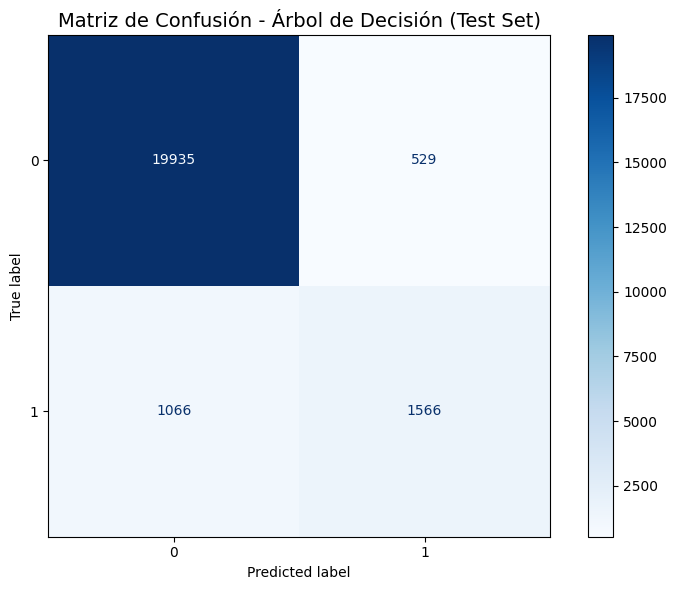


REPORTE DE CLASIFICACIÓN - TEST SET
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     20464
         1.0       0.75      0.59      0.66      2632

    accuracy                           0.93     23096
   macro avg       0.85      0.78      0.81     23096
weighted avg       0.93      0.93      0.93     23096


PARÁMETROS DEL ÁRBOL (tree)
Max Depth (configurado): 10
Profundidad Real:        10
Número de Hojas:         310
Número de Features:      6


In [101]:
# Evaluar el pipeline entrenado
metricas = evaluar_modelo(
    pipeline=pipeline_arbol,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    nombre_modelo="Árbol de Decisión"
)


In [102]:
# ===== CALCULAR GANANCIA EN TRAIN =====
ganancia_train = funcion_ganancia(pipeline_arbol, X_train, y_train)
print(f"Ganancia en Train: ${ganancia_train:,.0f}")

# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(pipeline_arbol, X_test, y_test)
print(f"Ganancia en Test: ${ganancia_test:,.0f}")

# ===== CALCULAR GANANCIA POR OBSERVACIÓN =====
ganancia_promedio_test = ganancia_test / len(y_test)
print(f"Ganancia promedio por observación: ${ganancia_promedio_test:.2f}")

Ganancia en Train: $350,500
Ganancia en Test: $137,350
Ganancia promedio por observación: $5.95


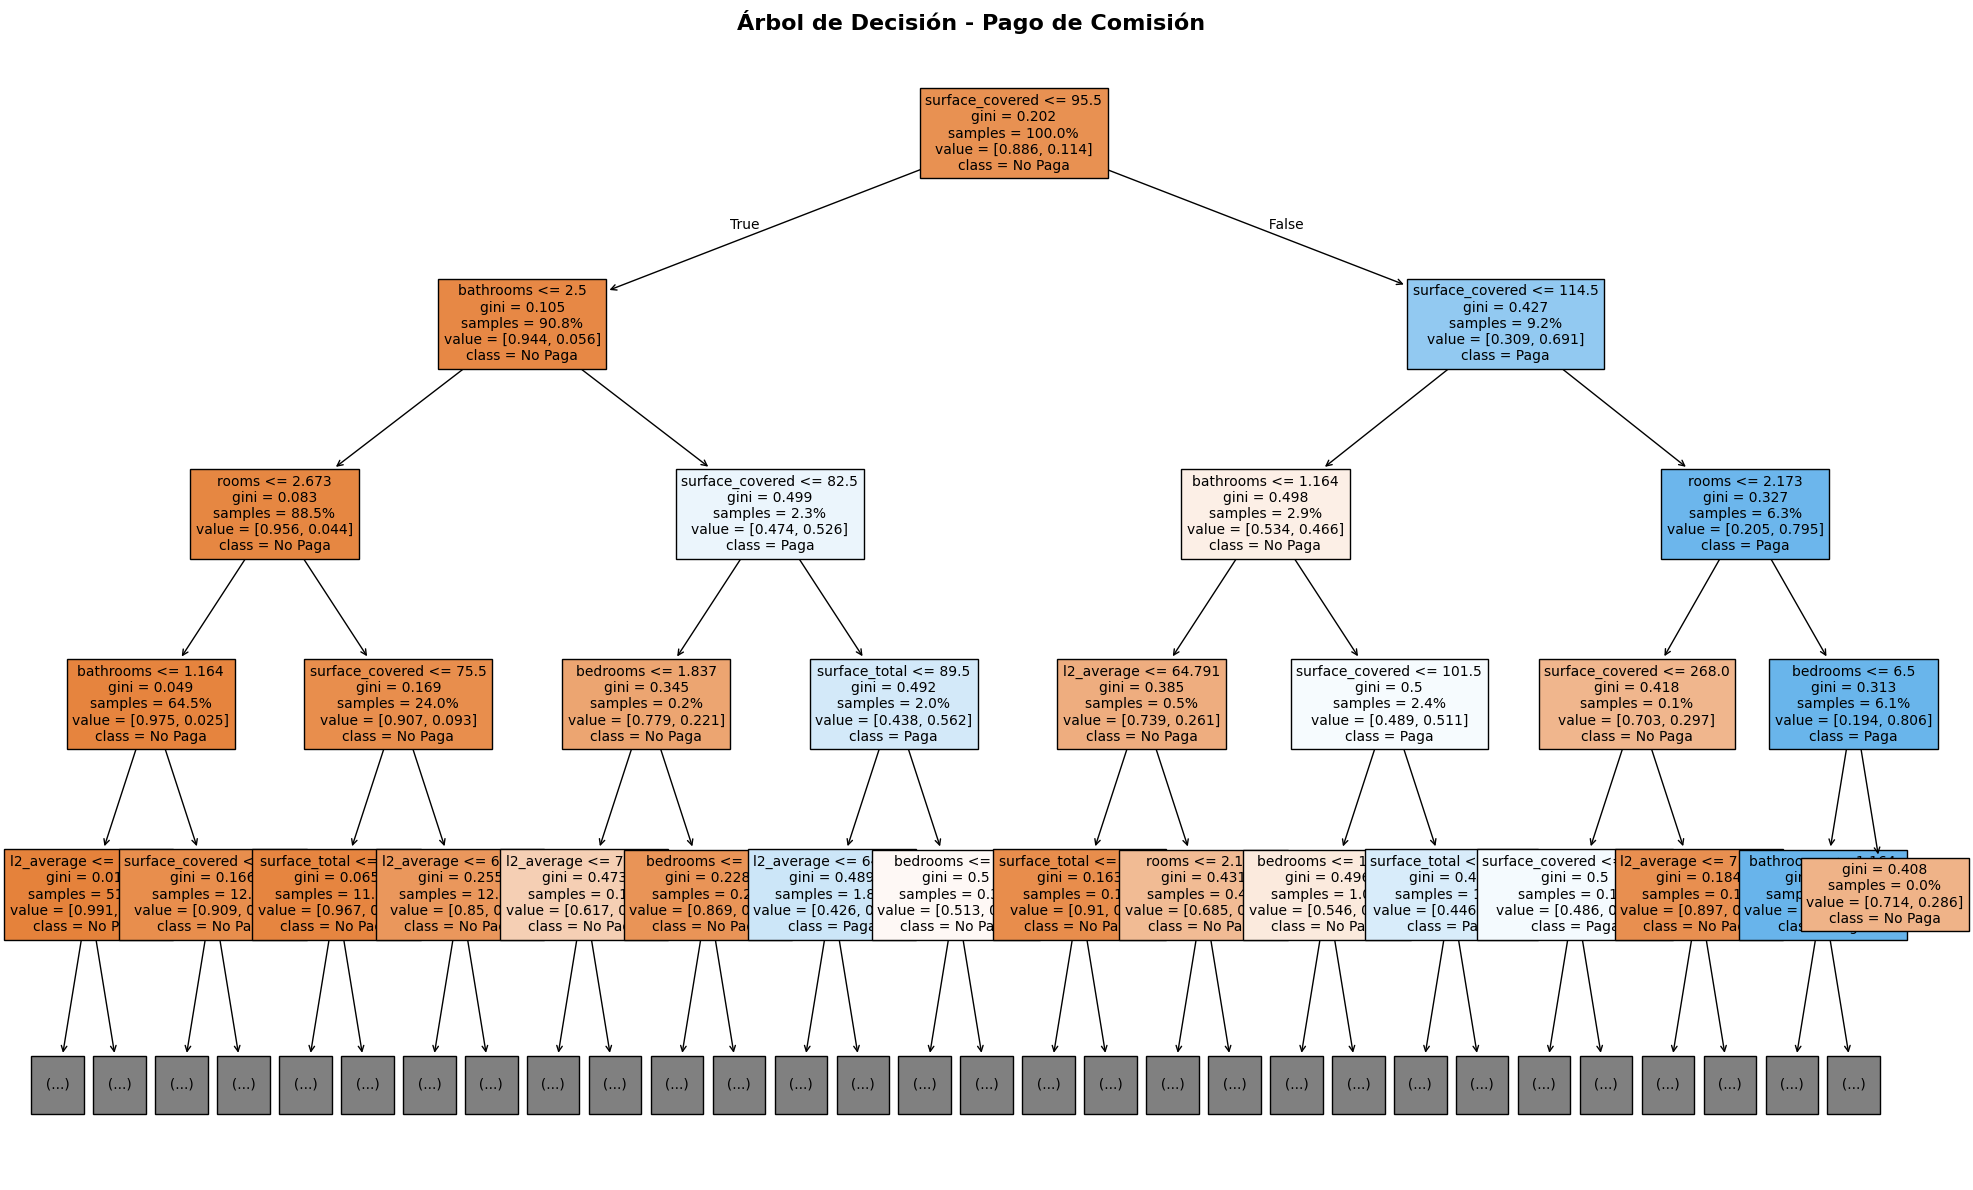


IMPORTANCIA DE LAS VARIABLES

Top 15 variables más importantes:
        Feature  Importance
surface_covered    0.706595
      bathrooms    0.149255
     l2_average    0.050166
  surface_total    0.041907
          rooms    0.033124
       bedrooms    0.018954


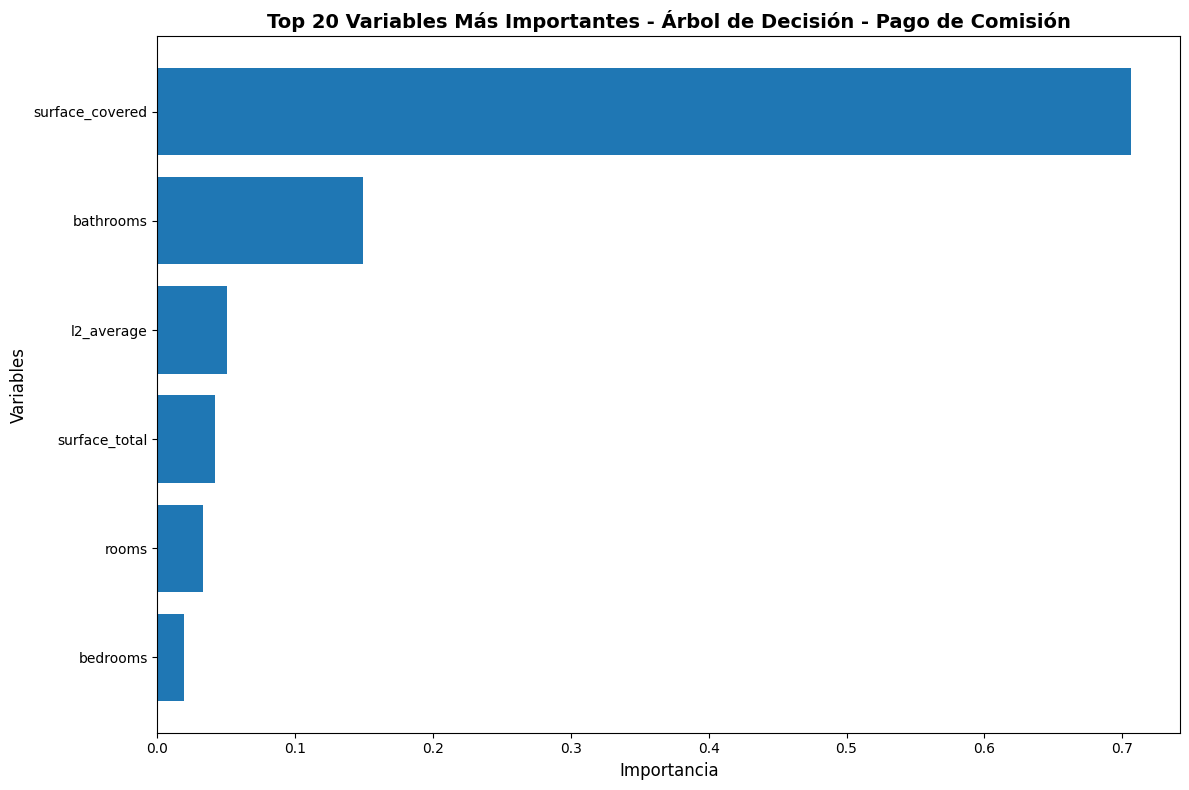

,Feature,Importance
4,surface_covered,0.706595
2,bathrooms,0.149255
5,l2_average,0.050166
3,surface_total,0.041907
0,rooms,0.033124
1,bedrooms,0.018954


In [103]:
visualizar_arbol_importancia(
    pipeline=pipeline_arbol,
    X_train=X_train,
    model_step_name='tree',
    class_names=['No Paga', 'Paga'],
    title='Árbol de Decisión - Pago de Comisión',
    max_depth_plot=4,
    top_n_features=20,
    top_n_print=15
)

Este modelo tiene una dependencia excesiva sobre la variable surface_covered, lo cuál no es un buen síntoma.

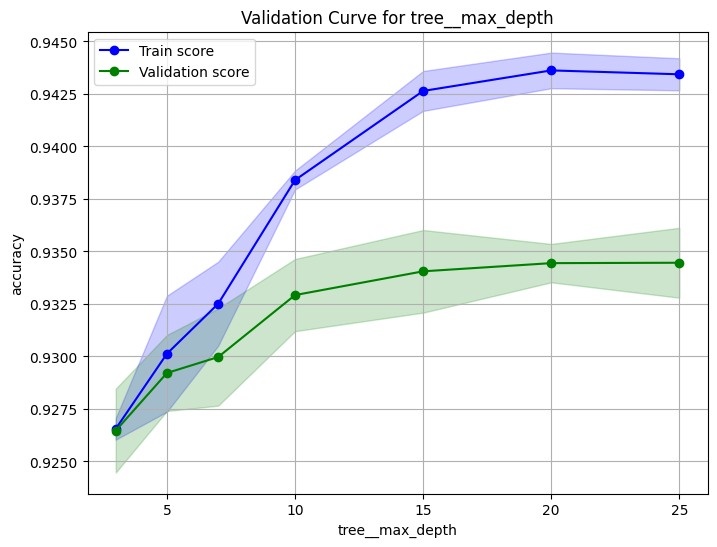

In [26]:
## CURVA DE VALIDACION
param_range = [3, 5, 7, 10, 15, 20,25]
plot_validation_curve(
    estimator=pipeline_arbol,
    X=X_train,
    y=y_train,
    param_name='tree__max_depth',  # pipe_step__hyperparam
    param_range=param_range,
    cv=5,
    scoring='accuracy'
)

Las diferencias de accuracy se ven recién en el segundo decimal, por lo que no parece estar sobreajustando el árbol. De igual forma, trabajaremos con valores cercanos al 7.5 donde los resultados son casi pares.

# Random Forest


In [33]:
from sklearn.ensemble import RandomForestClassifier

In [129]:
from sklearn.decomposition import PCA


pipeline_forest = Pipeline(
    steps=[
        ("outliers", OutlierHandler(columns=columnas_numericas, factor=2.25)),
        ("l2_avg", L2AverageAdder(l2_col="l2", target_col="surface_total")),
        ("dropper", ColumnDropper(columns=["lat", "lon", "ad_type", "start_date", "end_date", "created_on", "price_period", "title", "l1","l2", "l3", "l4", "l5", "l6"])),
        ("imputer_mean", ColumnImputer(imputer=SimpleImputer(strategy="mean"), columns=["rooms", "surface_total", "bathrooms", "bedrooms", "surface_covered", "l2_average"])),
        ("forest", RandomForestClassifier(
            criterion='gini',
            n_estimators=150,
            max_depth=15,
            min_samples_split = 4,
            min_samples_leaf = 2,
            max_features = 10,
            max_samples=0.9
        ))
    ])



In [130]:
pipeline_forest.fit(X_train, y_train)


,steps,"[('outliers', ...), ('l2_avg', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,columns,"['surface_total', 'rooms', ...]"
,factor,2.25
,l2_col,'l2'
,target_col,'surface_total'
,columns,"['lat', 'lon', ...]"
,imputer,SimpleImputer()
,columns,"['rooms', 'surface_total', ...]"


In [131]:
pipelines['Random_Forest'] = pipeline_forest


In [132]:
# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(pipeline_forest, X_test, y_test)
print(f"Ganancia en Test: ${ganancia_test:,.0f}")

Ganancia en Test: $160,100


In [133]:
#Predicciones con la probabilidad de corte
y_pred = (pipeline_forest.predict_proba(X_test)[:, 1] > 0.33)

In [134]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     20464
         1.0       0.71      0.76      0.74      2632

    accuracy                           0.94     23096
   macro avg       0.84      0.86      0.85     23096
weighted avg       0.94      0.94      0.94     23096



In [135]:
# Predicciones en train y test
from sklearn.metrics import accuracy_score

y_pred_train = pipeline_forest.predict(X_train)
y_pred_test = pipeline_forest.predict(X_test)

# Exactitud en train y test
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print("Exactitud en train: {:.2f}%".format(acc_train * 100))
print("Exactitud en test:  {:.2f}%".format(acc_test * 100))

Exactitud en train: 96.23%
Exactitud en test:  94.29%


Parece no haber un sobreajuste siginificativo, ya que la diferencia de accuracy entre train y test es muy baja.

In [137]:
# Obtengo las columnas de mi anteúltimo paso
preprocessor = pipeline_forest.named_steps['imputer_mean']  
feature_names = preprocessor.get_feature_names_out()

# Obtengo las importancia de mi clasificador RandomForest
classifier = pipeline_forest.named_steps['forest']  
importances = classifier.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)


print(feature_importance_df)

           Feature  Importance
4  surface_covered    0.583633
2        bathrooms    0.161667
3    surface_total    0.106093
5       l2_average    0.075747
1         bedrooms    0.039290
0            rooms    0.033571


Vemos que en un modelo complejo sigue habiendo mucha dependencia hacia la variable surface_covered.

### Random Forest con optimización de hiperparámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

best_score = 0
param_grid = {
    'forest__criterion': ['gini'], 
    'forest__max_depth': [8,12,16,20,25],
    'forest__min_samples_split': [8, 10, 12, 16],
    'forest__min_samples_leaf': [4, 6, 8],
    'forest__max_features': ["log2"],
    'forest__n_estimators': [90,120,150],
    'forest__max_samples': [0.8] # Añade bootstrap sampling
}

"""
# Crear el RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline_forest,
    param_distributions=param_grid,
    n_iter=1, # Número de combinaciones aleatorias a probar
    cv=4,
    scoring=funcion_ganancia,
    n_jobs=-1,
    verbose=2,
    random_state=42  # Opcional: para reproducibilidad
)"""

grid_search = GridSearchCV(
    estimator=pipeline_forest,
    param_grid=param_grid,
    cv=5,
    scoring=funcion_ganancia,
    n_jobs=-1,
    verbose=2,
)

# Entrenar
grid_search.fit(X_train, y_train)

# Mejores parámetros y score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)

# Hacer predicciones con el mejor modelo
y_pred = grid_search.predict(X_test)

# Acceder al mejor modelo
best_pipeline = grid_search.best_estimator_
pipelines['Random_Forest_gs'] = best_pipeline


Fitting 5 folds for each of 180 candidates, totalling 900 fits
Mejores parámetros: {'forest__criterion': 'gini', 'forest__max_depth': 20, 'forest__max_features': 'log2', 'forest__max_samples': 0.8, 'forest__min_samples_leaf': 4, 'forest__min_samples_split': 8, 'forest__n_estimators': 150}
Mejor score: 74330.0


In [174]:
# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(best_pipeline, X_test, y_test)
print(f"Ganancia en Test con RandomSearch: ${ganancia_test:,.0f}")

Ganancia en Test con RandomSearch: $157,600


In [175]:
#Predicciones con la probabilidad de corte
y_pred = (best_pipeline.predict_proba(X_test)[:, 1] > 0.33)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     20464
         1.0       0.70      0.76      0.73      2632

    accuracy                           0.94     23096
   macro avg       0.83      0.86      0.85     23096
weighted avg       0.94      0.94      0.94     23096



In [176]:
# Predicciones en train y test
from sklearn.metrics import accuracy_score

y_pred_train = best_pipeline.predict(X_train)
y_pred_test = best_pipeline.predict(X_test)

# Exactitud en train y test
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print("Exactitud en train: {:.2f}%".format(acc_train * 100))
print("Exactitud en test:  {:.2f}%".format(acc_test * 100))

Exactitud en train: 95.28%
Exactitud en test:  94.15%


Sobreajuste prácticamente inexistente, se mantiene el poder predictivo en datos nuevos.

# Naive Bayes

In [38]:
from sklearn.naive_bayes import MultinomialNB 

pipeline_bayes = Pipeline(
    steps=[
        ("outliers", OutlierHandler(columns=columnas_numericas, factor=2.25)),
        ("l2_avg", L2AverageAdder(l2_col="l2", target_col="surface_total")),
        ("dropper_preKNN", ColumnDropper(columns=["lat", "lon", "ad_type", "start_date", "end_date", "created_on", "price_period", "title", "l3", "l4", "l5", "l6", "bedrooms"], )),
        ("imputer_numericas", ColumnImputer(imputer=SimpleImputer(strategy="mean"), columns=["rooms", "bathrooms",  "surface_covered"])),
        ("imputer_categoricas", SimpleImputer(strategy="most_frequent")),  # ⬅️ Sin especificar columnas = imputa TODAS 
        # Codifica categóricas
        ("encoder", OneHotEncoder(sparse_output=False, dtype=int, drop='first', handle_unknown='ignore')),
        ("naive_bayes", MultinomialNB())
    ])


In [42]:
pipeline_bayes.fit(X_train, y_train)
pipelines['Naive_Bayes'] = pipeline_bayes




In [43]:
# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(pipeline_bayes, X_test, y_test)
print(f"Ganancia en Test: ${ganancia_test:,.0f}")

Ganancia en Test: $116,250


c:\Users\Gonzalo Ghiano\Desktop\2C2025\Ciencia de datos\Ejercicios\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [79]:
#Predicciones con la probabilidad de corte
y_pred = (pipeline_bayes.predict_proba(X_test)[:, 1] > 0.33)

c:\Users\Gonzalo Ghiano\Desktop\2C2025\Ciencia de datos\Ejercicios\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20464
         1.0       0.55      0.74      0.63      2632

    accuracy                           0.90     23096
   macro avg       0.76      0.83      0.79     23096
weighted avg       0.92      0.90      0.91     23096



# KNN

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

pipeline_knn = Pipeline(
    steps=[
        ("outliers", OutlierHandler(columns=columnas_numericas, factor=2.25)),
        ("l2_avg", L2AverageAdder(l2_col="l2", target_col="surface_total")),
        ("dropper_preKNN", ColumnDropper(columns=["lat", "lon", "ad_type", "start_date", "end_date", "created_on", "price_period", "title", "l1","l2", "l3", "l4", "l5", "l6"])),
        ("imputer", ColumnImputer(imputer=SimpleImputer(strategy="mean"), columns=["rooms", "surface_total", "bathrooms", "bedrooms", "surface_covered", "l2_average"])),
        ("bathrooms_squared", Column_squared(column='bathrooms')),
        ("dropper_final", ColumnDropper(columns=["bathrooms"])),
        ("scaler", StandardScaler()),
        ("knn_classifier", KNeighborsClassifier())
    ])

In [45]:
# Definir parámetros a probar
parametros = {
    'knn_classifier__n_neighbors': np.arange(1, 40, 2)  # ⬅️ Nombre del paso + parámetro
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline_knn, 
    parametros, 
    cv=5,
    scoring=funcion_ganancia, 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_knn_pipeline = grid_search.best_estimator_
# Mejores parámetros y score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)

pipelines['KNN'] = best_knn_pipeline



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'knn_classifier__n_neighbors': np.int64(13)}
Mejor score: 66870.0


In [46]:
# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(best_knn_pipeline, X_test, y_test)
print(f"Ganancia en Test: ${ganancia_test:,.0f}")

Ganancia en Test: $143,050


In [82]:
#Predicciones con la probabilidad de corte
y_pred = (best_knn_pipeline.predict_proba(X_test)[:, 1] > 0.33)

In [83]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96     20464
         1.0       0.67      0.72      0.69      2632

    accuracy                           0.93     23096
   macro avg       0.82      0.84      0.83     23096
weighted avg       0.93      0.93      0.93     23096



# KNN + PCA

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


pipeline_knn_pca = Pipeline(
    steps=[
        ("outliers", OutlierHandler(columns=columnas_numericas, factor=2.25)),
        ("l2_avg", L2AverageAdder(l2_col="l2", target_col="surface_total")),
        ("dropper_preKNN", ColumnDropper(columns=["lat", "lon", "ad_type", "start_date", "end_date", "created_on", "price_period", "title", "l1","l2", "l3", "l4", "l5", "l6"])),
        ("imputer", ColumnImputer(imputer=SimpleImputer(strategy="mean"), columns=["rooms", "surface_total", "bathrooms", "bedrooms", "surface_covered", "l2_average"])),
        ("bathrooms_squared", Column_squared(column='bathrooms')),
        ("dropper_final", ColumnDropper(columns=["bathrooms"])),
        ("scaler", StandardScaler()),
        ("pca", PCA()),  # Retiene 95% de varianza
        ("knn_classifier", KNeighborsClassifier())
    ])

In [49]:
# Definir parámetros a probar
parametros = {
    'knn_classifier__n_neighbors': np.arange(1, 40, 2),
    'knn_classifier__weights': ['uniform', 'distance'],
    'pca__n_components': [0.95, 0.90, 0.85, 0.80, 0.75]
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline_knn_pca, 
    parametros, 
    cv=5,
    scoring=funcion_ganancia, 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_knn_pca_pipeline = grid_search.best_estimator_
# Mejores parámetros y score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)

pipelines['KNN_PCA_gs'] = best_knn_pca_pipeline


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejores parámetros: {'knn_classifier__n_neighbors': np.int64(37), 'knn_classifier__weights': 'distance', 'pca__n_components': 0.95}
Mejor score: 71540.0


In [67]:
# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(best_knn_pca_pipeline, X_test, y_test)
print(f"Ganancia en Test: ${ganancia_test:,.0f}")

Ganancia en Test: $153,850


Ganancia en Test: $153,850 para el mejor modelo encontrado, un muy buen resultado, apenas por debajo del random forest.

In [102]:
#Predicciones con la probabilidad de corte
y_pred = (best_knn_pca_pipeline.predict_proba(X_test)[:, 1] > 0.33)

In [103]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     20464
         1.0       0.69      0.76      0.72      2632

    accuracy                           0.93     23096
   macro avg       0.83      0.86      0.84     23096
weighted avg       0.94      0.93      0.93     23096



In [101]:
# Predicciones en train y test
from sklearn.metrics import accuracy_score

y_pred_train = best_knn_pca_pipeline.predict(X_train)
y_pred_test = best_knn_pca_pipeline.predict(X_test)

# Exactitud en train y test
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print("Exactitud en train: {:.2f}%".format(acc_train * 100))
print("Exactitud en test:  {:.2f}%".format(acc_test * 100))

Exactitud en train: 97.65%
Exactitud en test:  93.87%


No notamos una gran pérdida del poder predictivo en los datos de test por lo que asumimos que tenemos un sobreajuste aceptable.
La caída de rendimiento es un poco mayor que la observada en el random forest.

## Curvas ROC y puntos de corte

In [94]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_all_roc_curves(pipelines, X_test, y_test, figsize=(10, 8)):
    """
    Grafica las curvas ROC de múltiples pipelines en un solo gráfico.
    
    Parameters
    ----------
    pipelines : dict
        Diccionario con nombre_pipeline: pipeline_object
    X_test : DataFrame
        Datos de test
    y_test : Series/array
        Etiquetas de test
    figsize : tuple
        Tamaño de la figura
    """
    plt.figure(figsize=figsize)
    
    # Colores automáticos
    colors = plt.cm.tab10(range(len(pipelines)))
    
    for (name, pipeline), color in zip(pipelines.items(), colors):
        # Obtener probabilidades predichas
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calcular curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        # Graficar
        plt.plot(fpr, tpr, color=color, lw=2, 
                label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Línea diagonal (clasificador aleatorio)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Azar (AUC = 0.500)')
    
    # Configuración del gráfico
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Comparación de Curvas ROC', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


c:\Users\Gonzalo Ghiano\Desktop\2C2025\Ciencia de datos\Ejercicios\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


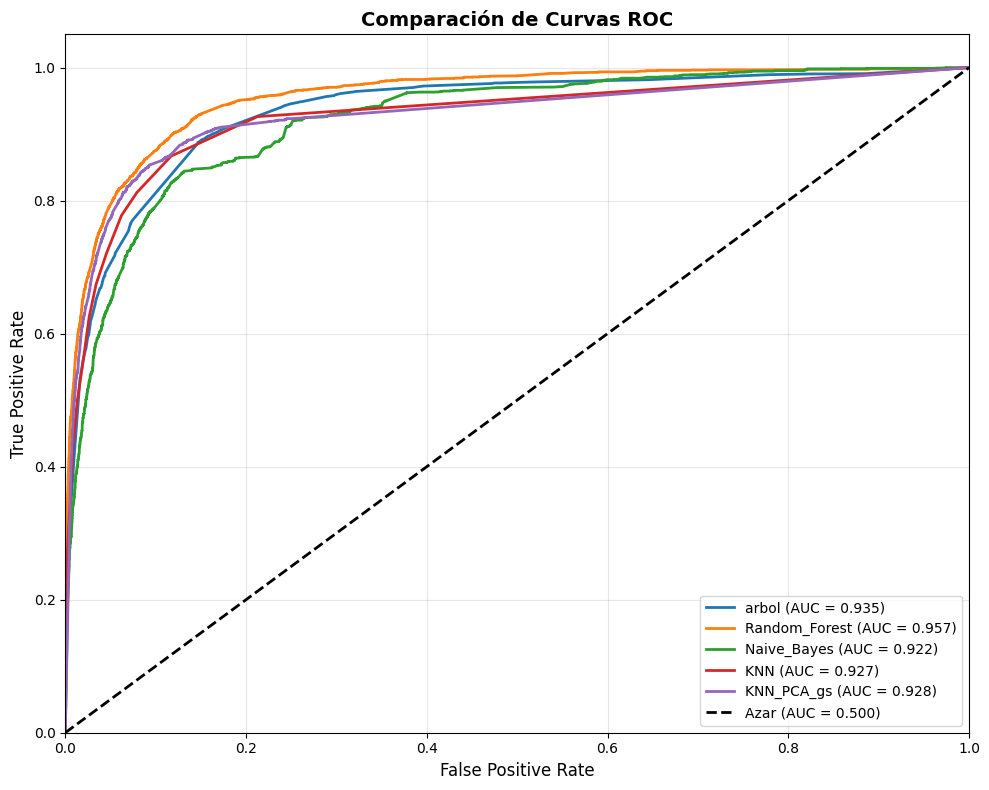

In [96]:
plot_all_roc_curves(pipelines, X_test, y_test)

Los modelos evaluados poseen un elevado valor de AUC, mostrando poder para discriminar entre ambas clases. Además, obtienen rápidamente un TPR elevado, acercandose a la esquina superior izquierda.
Es oportuno aclara que aunque la curva ROC muestra puntos óptimos de corte en valor cercanos a 0.2, nosotros utilizamos la función de ganancia para establecer el mismo en 0.33

In [ ]:
from sklearn.metrics import make_scorer

def scoring_ganancia(y_true, y_pred):
    ganancia = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 1:  # Si predecimos que pagará
            if y_true.iloc[i] == 1:  # Y realmente paga
                ganancia += 100
            else:  # Pero no paga
                ganancia -= 50
    
    return ganancia

# Crear el scorer
scorer_ganancia = make_scorer(scoring_ganancia, greater_is_better=True)

In [ ]:
from sklearn.model_selection import TunedThresholdClassifierCV

# Entrenar tu clasificador base primero
base_classifier = pipelines["Random_Forest"].fit(X_train, y_train)

# Crear el clasificador con umbral ajustado
tuned_clf = TunedThresholdClassifierCV(
    estimator=base_classifier,
    scoring=scorer_ganancia,
    cv=5,  # validación cruzada de 5 folds
    n_jobs=-1,  # usar todos los cores
    store_cv_results=True  # guardar resultados de CV
)

tuned_clf.fit(X_train, y_train)

# Ver el umbral óptimo encontrado
print(f"Umbral óptimo encontrado: {tuned_clf.best_threshold_:.3f}")

Umbral óptimo encontrado: 0.343


Vemos que el umbral encontrado por la librería es prácticamente el mismo que el cálculado manualmente por nosotros, dándole más sustento a nuestra decisión de utilizar 0.33 como punto de corte.

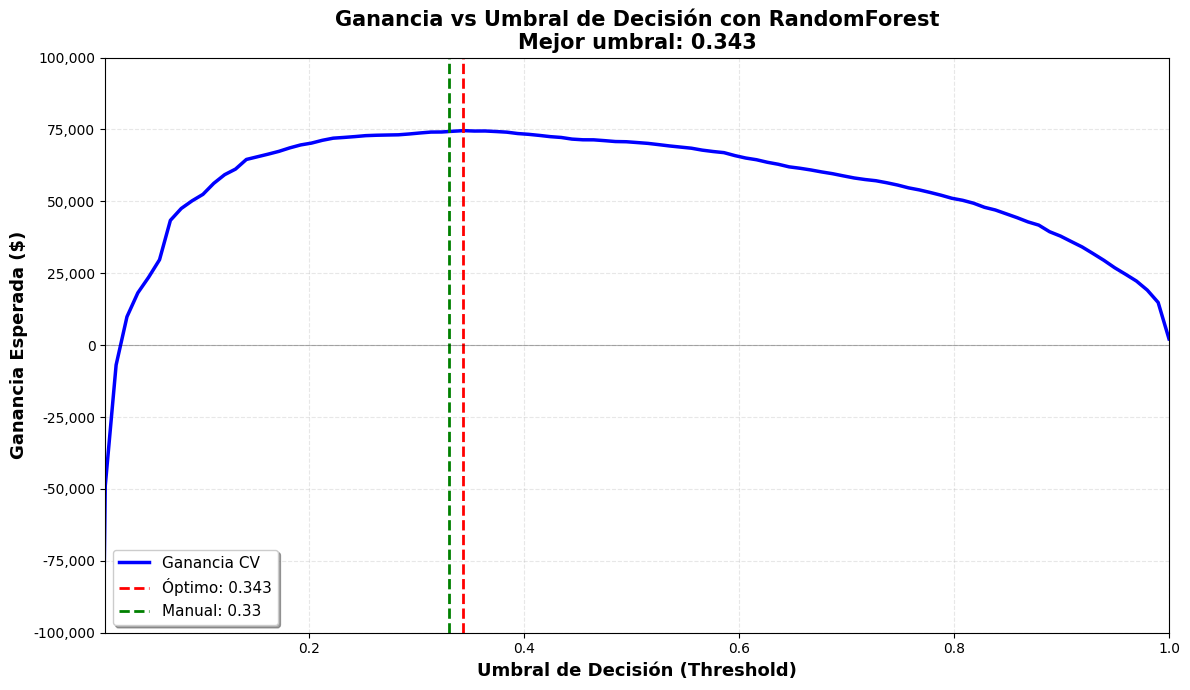

In [ ]:
import matplotlib.pyplot as plt

# Extraer datos
thresholds = tuned_clf.cv_results_['thresholds']
scores = tuned_clf.cv_results_['scores']

plt.figure(figsize=(12, 7))
plt.plot(thresholds, scores, 'b-', linewidth=2.5, label='Ganancia CV')

# Líneas verticales para los umbrales
plt.axvline(tuned_clf.best_threshold_, color='red', linestyle='--', 
            linewidth=2, label=f'Óptimo: {tuned_clf.best_threshold_:.3f}')
plt.axvline(0.33, color='green', linestyle='--', 
            linewidth=2, label='Manual: 0.33')

# Etiquetas y título
plt.xlabel('Umbral de Decisión (Threshold)', fontsize=13, fontweight='bold')
plt.ylabel('Ganancia Esperada ($)', fontsize=13, fontweight='bold')
plt.title(f'Ganancia vs Umbral de Decisión con RandomForest\nMejor umbral: {tuned_clf.best_threshold_:.3f}', 
          fontsize=15, fontweight='bold')

plt.legend(loc='lower left', fontsize=11, frameon=True, shadow=True)
plt.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
plt.grid(True, alpha=0.3, linestyle='--')

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Ajustar límites
plt.xlim([0.01, 1])
plt.ylim([-100000, 100000])

plt.tight_layout()
plt.show()


Aquí mostramos como evoluciona la ganancia esperada a con diferentes puntos de corte, siendo estos evaluados bajo las predicciones de un modelo base Random Forest.